# Supply trend with market rates
This is an example combining functionality from our *Voyages*, *Market Rates* and *Tonnage List* APIs. The aim of the example is to plot a supply trend with superimposed, predicted market rates, in order to get a hollistic view of market behaviour during a specific period, for a specific load port, and a specific vessel class.

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/Combined%20Examples/Supply%20trend%20with%20market%20rates.ipynb) 

## Setup
Install the Signal Ocean SDK:

In [28]:
!pip install signal-ocean


[notice] A new release of pip available: 22.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Import required dependencies:

In [12]:
from datetime import date, timedelta

import pandas as pd
import matplotlib.pyplot as plt

from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
from signal_ocean.market_rates import MarketRatesAPI, CargoId
from signal_ocean.tonnage_list import (
    TonnageListAPI,
    VesselClassFilter,
    PortFilter,
    VesselFilter,
    PushType,
    MarketDeployment,
    CommercialStatus,
    VesselSubclass,
    IndexLevel,
    DateRange,
)


Get your personal Signal Ocean API subscription key (acquired [here](https://apis.signalocean.com/profile)) and use it to create a `Connection`:

In [13]:
signal_ocean_api_key = ""  # replace with your subscription key
connection = Connection(signal_ocean_api_key)

Create instances of APIs used throughout this notebook:

In [14]:
voyage_api = VoyagesAPI(connection)
tonnage_list_api = TonnageListAPI(connection)
market_rate_api = MarketRatesAPI(connection)

## Parametrization

In order to plot a supply trend with the predicted market rates, we need to specify the following parameters for our queries:
1. `vessel_class` - the class of queried vessels.
1. `load_port` - the loading port.
1. `days_back` - the number of days the supply trend should reach back, starting from the current date.
1. `laycan_end_in_days` - the maximum estimated time of arrival for available vessels to reach the loading port.
1. `push_type` - the vessels' push status, if available from the emails in your account.
1. `market_deployment` - the vessels' market deployment. 
1. `commercial_status` - commercial status of the vessels at each point in time.
1. `vessel_subclass` - the type of oil product the vessel is classified to carry.
1. `ais_since` - how many days since the vessel has transmitted its AIS data.
1. `route_description` - the route of interest with available market rates.

In [15]:
vessel_class_filter = VesselClassFilter(name_like="Aframax")
load_port_filter = PortFilter(name_like="Ceyhan")
days_back = 90
laycan_end_in_days = 10

vessel_filter = VesselFilter(
    push_types=[PushType.PUSHED_POSS, PushType.PUSHED],
    market_deployments=[MarketDeployment.RELET, MarketDeployment.SPOT],
    commercial_statuses=[
        CommercialStatus.AVAILABLE,
        CommercialStatus.ON_SUBS,
        CommercialStatus.FAILED,
        CommercialStatus.CANCELLED,
    ],
    vessel_subclass=VesselSubclass.DIRTY,
    latest_ais_since=5,
)

route_description = "Afra - Cross Med"

today = date.today()
start_date = today - timedelta(days=days_back)
end_date = today


For more information, see the [Tonnage List](../../../../tonnage_list) and  [Market Rate](../../../../market_rates) API sections.

## Retrieve the historical tonnage list

In [16]:
vessel_class = tonnage_list_api.get_vessel_classes(vessel_class_filter)[0]
load_port = tonnage_list_api.get_ports(load_port_filter)[0]

htl = tonnage_list_api.get_historical_tonnage_list(
    load_port,
    vessel_class,
    laycan_end_in_days,
    DateRange(start_date, end_date),
    vessel_filter,
)

htl_for_supply_trend = htl.to_data_frame()
htl_for_supply_trend


name vessel_class ice_class  \
date                      imo                                                 
2023-07-03 12:00:00+00:00 9253325             Nurkez      Aframax       NaN   
                          9694658  Nissos Christiana      Aframax       NaN   
                          9408530          Southport      Aframax       NaN   
                          9243021       Desh Rakshak      Aframax       NaN   
                          9338905       Aegean Power      Aframax       NaN   
...                                              ...          ...       ...   
2023-04-04 12:00:00+00:00 9440526     Minerva Elpida      Aframax       NaN   
                          9777931              Ryman      Aframax        1A   
                          9402483      Dubai Glamour      Aframax       NaN   
                          9693056    Agios Gerasimos      Aframax       NaN   
                          9800568     Hibernian Tide      Aframax        1A   

                                   year_built  deadweight  length_overall  \
date                      imo                                               
2023-07-03 12:00:00+00:00 9253325        2004      105650          248.00   
                          9694658        2015      114264          252.00   
                          9408530        2008      115462          249.99   
                          9243021        2003      113918          244.20   
                          9338905        2007      115754          248.95   
...                                       ...         ...             ...   
2023-04-04 12:00:00+00:00 9440526        2010      112793          249.96   
                          9777931        2017      112870          250.00   
                          9402483        2009      115600          250.00   
                          9693056        2015      109999          249.90   
                          9800568        2019      109896          255.90   

                                   breadth_extreme subclass  \
date                      imo                                 
2023-07-03 12:00:00+00:00 9253325               43    Dirty   
                          9694658               45    Dirty   
                          9408530               44    Dirty   
                          9243021               42    Dirty   
                          9338905               44    Dirty   
...                                            ...      ...   
2023-04-04 12:00:00+00:00 9440526               44    Dirty   
                          9777931               44    Dirty   
                          9402483               44    Dirty   
                          9693056               44    Dirty   
                          9800568               44    Dirty   

                                  market_deployment_point_in_time  \
date                      imo                                       
2023-07-03 12:00:00+00:00 9253325                           Relet   
                          9694658                            Spot   
                          9408530                            Spot   
                          9243021                           Relet   
                          9338905                            Spot   
...                                                           ...   
2023-04-04 12:00:00+00:00 9440526                            Spot   
                          9777931                            Spot   
                          9402483                            Spot   
                          9693056                            Spot   
                          9800568                            Spot   

                                  push_type_point_in_time  ...  \
date                      imo                              ...   
2023-07-03 12:00:00+00:00 9253325                  Pushed  ...   
                          9694658                  Pushed  ...   
                          9408530   

## Get daily market rates for the route
We'll need a helper function to find our desired route for the market rates:

In [17]:
def return_selected_route(vessel_class, route_description):
    vessel_routes = market_rate_api.get_routes(vessel_class_id=vessel_class.id)
    for i, v in enumerate(vessel_routes):
        if vessel_routes[i].description == route_description:
            break
    return vessel_routes[i]


Which we can use to find the route object returned from the Market Rates API:

In [18]:
market_rate_route = return_selected_route(vessel_class, route_description)


And use it to query for market rates:

In [19]:
market_rates = market_rate_api.get_market_rates(
    start_date,
    route_id=market_rate_route.id,
    vessel_class_id=vessel_class.id,
    end_date=end_date,
    cargo_id=CargoId(market_rate_route.cargo_id)
)

market_rates = pd.DataFrame([vars(vr) for vr in market_rates])
market_rates["rate_date"] = pd.to_datetime(market_rates["rate_date"])
market_rates.set_index("rate_date", inplace=True)
market_rates


,route_id,rate_value,unit,vessel_class_id,deprecated_to
rate_date,,,,,
2023-04-04,R1,207.5,WS,86,None
2023-04-05,R1,217.5,WS,86,None
2023-04-06,R1,212.5,WS,86,None
2023-04-07,R1,212.5,WS,86,None
2023-04-08,R1,212.5,WS,86,None
...,...,...,...,...,...
2023-06-29,R1,140.0,WS,86,None
2023-06-30,R1,137.5,WS,86,None
2023-07-01,R1,137.5,WS,86,None


## Plot the daily supply trend with market rates

C:\Users\Kimon\AppData\Local\Temp\ipykernel_5952\1394344043.py:1: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.



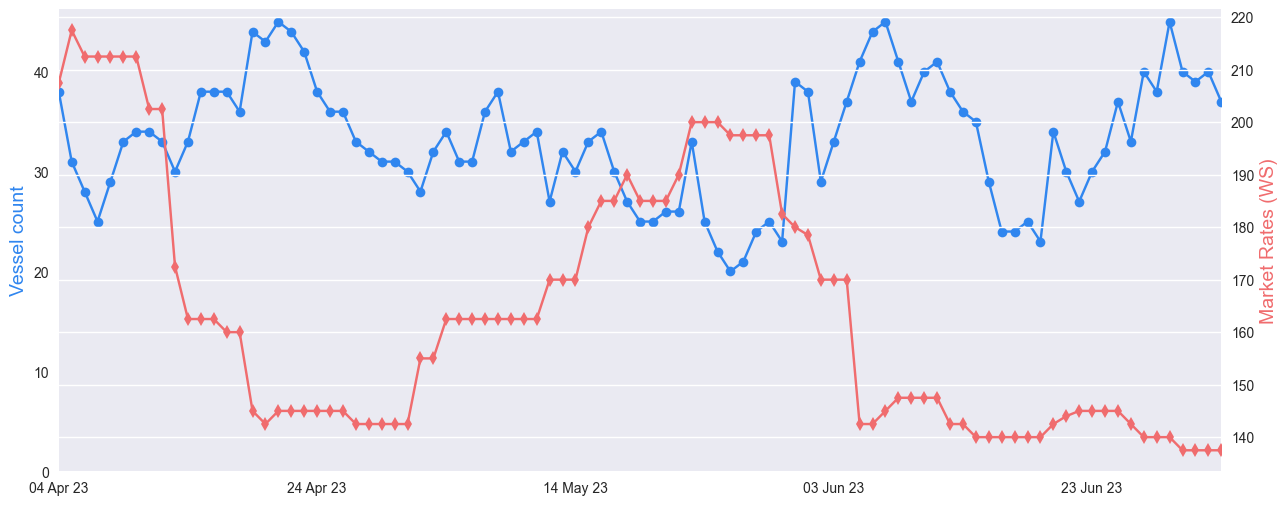

In [20]:
plt.style.use("seaborn")
fig, axs = plt.subplots(figsize=(15, 6))

supply_trend = htl_for_supply_trend.groupby(IndexLevel.DATE, sort=True).size()
supply_trend.index = supply_trend.index.strftime("%d %b %y")

# Left axis (Supply plot)
supply_plot = supply_trend.plot(ax=axs, x="date", color="#3086EF", marker="o")
supply_plot.set_ylabel(
    "Vessel count", color=plt.gca().lines[-1].get_color(), fontsize=14
)
supply_plot.set_ylim(ymin=0)

# Right axis (Market rate plot)
market_rates.index = market_rates.index.strftime("%d %b %y")
mr_plot = market_rates.plot(
    ax=axs, y="rate_value", secondary_y=True, color="#F06C6E", marker="d"
)
mr_plot.set_ylabel(
    "Market Rates (WS)", color=plt.gca().lines[-1].get_color(), fontsize=14
)

axs.set_xlim(0, len(supply_trend) - 1)
axs.set_xlabel("")
axs.get_legend().remove()


## Perform a point-to-point comparison

Here's an example of a workflow to compare two different points in time.

Specify the dates to compare:

In [21]:
point_a = today - timedelta(days=1)
point_b = today - timedelta(days=5)


In [22]:
dates = htl_for_supply_trend.index.get_level_values("date").date

if not any(dates == point_a):
    print("Point A is not within imported date values.")
elif not any(dates == point_b):
    print("Point B is not within imported date values.")

vessels_in_a = htl_for_supply_trend.loc[(dates == point_a)]
vessels_in_b = htl_for_supply_trend.loc[(dates == point_b)]


### Intersection of Vessel IMOs

In [23]:
intersection = pd.merge(
    vessels_in_a.add_suffix("_IN_A"),
    vessels_in_b.add_suffix("_IN_B"),
    how="inner",
    on="imo",
)

intersection


,name_IN_A,vessel_class_IN_A,ice_class_IN_A,year_built_IN_A,deadweight_IN_A,length_overall_IN_A,breadth_extreme_IN_A,subclass_IN_A,market_deployment_point_in_time_IN_A,push_type_point_in_time_IN_A,...,open_prediction_accuracy_point_in_time_IN_B,open_country_point_in_time_IN_B,open_narrow_area_point_in_time_IN_B,open_wide_area_point_in_time_IN_B,availability_port_type_point_in_time_IN_B,availability_date_type_point_in_time_IN_B,fixture_type_point_in_time_IN_B,current_vessel_sub_type_id_point_in_time_IN_B,current_vessel_sub_type_point_in_time_IN_B,willing_to_switch_current_vessel_sub_type_point_in_time_IN_B
imo,,,,,,,,,,,,,,,,,,,,,
9235000,Coatlicue,Aframax,NaN,2001,105322,239.00,42,Dirty,Spot,Pushed,...,Narrow Area,Egypt,Red Sea,Red Sea,Source,Source,NaN,1,Source,False
9243021,Desh Rakshak,Aframax,NaN,2003,113918,244.20,42,Dirty,Relet,Pushed,...,Narrow Area,Egypt,Red Sea,Red Sea,Source,Source,NaN,1,Source,False
9247390,Tornado A,Aframax,NaN,2003,105411,239.00,42,Dirty,Relet,Pushed,...,Narrow Area,Greece,East Mediterranean,Mediterranean,Source,Source,NaN,1,Source,False
9792864,Alkinoos,Aframax,1A,2019,109900,255.90,44,Dirty,Spot,Pushed POSS,...,Narrow Area,Turkey,East Mediterranean,Mediterranean,Prediction,Prediction,NaN,1,Prediction,False
9453030,Valpiave,Aframax,NaN,2010,115909,248.97,44,Dirty,Relet,Pushed,...,Port,Romania,Black Sea,Black Sea / Sea Of Marmara,Source,Prediction,NaN,1,Prediction,False
9317951,Minerva Libra,Aframax,1A,2007,116779,249.88,44,Dirty,Spot,Pushed,...,Narrow Area,Turkey,East Mediterranean,Mediterranean,Source,Source,NaN,1,Source,False
9395331,Corossol,Aframax,NaN,2010,106898,243.80,42,Dirty,Spot,Pushed,...,Narrow Area,Egypt,Red Sea,Red Sea,Source,Source,NaN,1,Source,False
9334727,Dugi Otok,Aframax,1C,2008,108932,246.00,48,Dirty,Spot,Pushed,...,Port,Croatia,Central Mediterranean,Mediterranean,Source,Prediction,NaN,1,Prediction,False
9253325,Nurkez,Aframax,NaN,2004,105650,248.00,43,Dirty,Relet,Pushed,...,Narrow Area,Yemen,Red Sea,Red Sea,Source,Source,NaN,1,Source,False


### Difference between vessel IMOs in relation to point A

In [24]:
vessels_in_a_but_not_in_b = (
    vessels_in_a.add_suffix("_IN_A")
    .merge(
        vessels_in_b.add_suffix("_IN_B"), indicator=True, how="left", on="imo"
    )
    .loc[lambda x: x["_merge"] != "both"]
)

vessels_in_a_but_not_in_b


,name_IN_A,vessel_class_IN_A,ice_class_IN_A,year_built_IN_A,deadweight_IN_A,length_overall_IN_A,breadth_extreme_IN_A,subclass_IN_A,market_deployment_point_in_time_IN_A,push_type_point_in_time_IN_A,...,open_country_point_in_time_IN_B,open_narrow_area_point_in_time_IN_B,open_wide_area_point_in_time_IN_B,availability_port_type_point_in_time_IN_B,availability_date_type_point_in_time_IN_B,fixture_type_point_in_time_IN_B,current_vessel_sub_type_id_point_in_time_IN_B,current_vessel_sub_type_point_in_time_IN_B,willing_to_switch_current_vessel_sub_type_point_in_time_IN_B,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9281009,Everest Spirit,Aframax,NaN,2004,115047,249.90,44,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9408322,Tarbet Spirit,Aframax,NaN,2009,107529,243.80,42,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9795050,Eagle Brisbane,Aframax,NaN,2018,113458,250.00,44,Dirty,Relet,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9294551,Hydra,Aframax,NaN,2004,105744,240.10,42,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9927196,Green Admire,Aframax,NaN,2022,114377,249.99,44,Dirty,Relet,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9271377,Trident Hope,Aframax,NaN,2003,105985,241.03,42,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9527855,Alicante,Aframax,NaN,2013,115708,248.97,44,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9407457,Matilda,Aframax,NaN,2009,112935,249.96,44,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9329409,Kriti Samaria,Aframax,NaN,2007,105865,241.03,42,Dirty,Relet,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


### Difference between vessel IMOs in relation to point B

In [25]:
vessels_in_b_but_not_in_a = (
    vessels_in_b.add_suffix("_IN_B")
    .merge(
        vessels_in_a.add_suffix("_IN_A"), indicator=True, how="left", on="imo"
    )
    .loc[lambda x: x["_merge"] != "both"]
)

vessels_in_b_but_not_in_a

,name_IN_B,vessel_class_IN_B,ice_class_IN_B,year_built_IN_B,deadweight_IN_B,length_overall_IN_B,breadth_extreme_IN_B,subclass_IN_B,market_deployment_point_in_time_IN_B,push_type_point_in_time_IN_B,...,open_country_point_in_time_IN_A,open_narrow_area_point_in_time_IN_A,open_wide_area_point_in_time_IN_A,availability_port_type_point_in_time_IN_A,availability_date_type_point_in_time_IN_A,fixture_type_point_in_time_IN_A,current_vessel_sub_type_id_point_in_time_IN_A,current_vessel_sub_type_point_in_time_IN_A,willing_to_switch_current_vessel_sub_type_point_in_time_IN_A,_merge
imo,,,,,,,,,,,,,,,,,,,,,
9293155,Wonder Vega,Aframax,NaN,2005,106062,244.00,42,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9796743,Rava,Aframax,1C,2017,114385,250.00,44,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9516959,Belmar,Aframax,1C,2011,115904,248.97,44,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9899296,Calypso,Aframax,NaN,2021,111930,237.00,44,Dirty,Spot,Pushed POSS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9297345,Ursus Maritimus,Aframax,1A,2005,113782,251.51,44,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9250543,Wonder Avior,Aframax,NaN,2004,106162,243.96,42,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9264570,Themis,Aframax,NaN,2002,105965,241.03,42,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9927201,Green Adventure,Aframax,NaN,2022,113500,249.99,44,Dirty,Relet,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9592264,Nissos Serifos,Aframax,NaN,2012,115689,248.97,44,Dirty,Spot,Pushed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
